In [86]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.base import BaseEstimator, RegressorMixin
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [87]:
credits = pd.read_csv("tmdb_movie_metadata/tmdb_5000_credits.csv")
credits.rename(columns={'movie_id': 'id'}, inplace=True)
credits.drop("title", axis=1, inplace=True, )
movies = pd.read_csv("tmdb_movie_metadata/tmdb_5000_movies.csv")
data = movies.merge(credits, on="id")

data = data[data['revenue'] != 0]
data = data[data['budget'] != 0]

In [88]:
class cast_member:
    def __init__(self, name, character, gender):
        self.name = name
        self.character = character
        self.gender = gender

class crew_member:
    def __init__(self, name, job, department):
        self.name = name
        self.job = job
        self.department = department

In [89]:
def convert_dict_to_1d_list(json_str):
    json_dict = json.loads(json_str)
    return_list = []
    for item in json_dict:
        return_list.append(item['name'])
    return return_list

def convert_dict_to_class_list(json_str, class_type, dimension1, dimension2, dimension3='none'):
    json_dict = json.loads(json_str)
    return_list = []
    for item in json_dict:
        if class_type == 'cast_members':
            gender = item.get(dimension3, None)
            tmp_person = cast_member(item[dimension1], item[dimension2], gender)
            return_list.append(tmp_person)
        elif class_type == 'crew_members':
            department = item.get(dimension3, None)
            tmp_person = crew_member(item[dimension1], item[dimension2], department)
            return_list.append(tmp_person)
    return return_list

def get_director(crew_list):
    for item in crew_list:
        if item.job == 'Director':
            return item.name
    return 'none'

def get_crew_member_count_by_job(crew_list, job_type):
    crew_member_count = 0
    for item in crew_list:
        if job_type in item.job:
            crew_member_count += 1
    return crew_member_count

def get_department_size(crew_list, department):
    department_size = 0
    for item in crew_list:
        if department in item.department:
            department_size += 1
    return department_size

def get_cast_number(cast_list, gender):
    cast_count = 0
    for item in cast_list:
        if str(item.gender) == str(gender):
            cast_count += 1
    return cast_count

In [90]:
x = data.copy()

x['genres']  =  x['genres'].apply(convert_dict_to_1d_list)
x['keywords'] = x['keywords'].apply(convert_dict_to_1d_list)
x['production_companies'] = x['production_companies'].apply(convert_dict_to_1d_list)
x['production_countries'] = x['production_countries'].apply(convert_dict_to_1d_list)

x['country'] = x['production_countries'].apply(lambda x:x[0] if len(x)>0 else None)

x['cast'] = x['cast'].apply(convert_dict_to_class_list,
                                                              args=('cast_members', 'name', 'character', 'gender'))
x['crew'] = x['crew'].apply(convert_dict_to_class_list,
                                                              args=('crew_members', 'name', 'job', 'department'))

x['director_name'] = x['crew'].apply(get_director)

x['dominant_genre'] = x['genres'].apply(lambda x:x[0] if len(x)>0 else 'none')

x['title_year'] = pd.to_datetime(x['release_date']).apply(lambda x:0 if pd.isnull(x.year) else int(x.year))

x['release_week'] = pd.to_datetime(x['release_date']).apply(lambda x:0 if pd.isnull(x.week) else int(x.week))

x['cast_size'] = x['cast'].apply(lambda x:len(x) if len(x)>0 else 0)
x['crew_size'] = x['crew'].apply(lambda x:len(x) if len(x)>0 else 0)
x['number_production_companies'] = x['production_companies'].apply(lambda x:len(x) if len(x)>0 else 0)

x['director_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Director',))
x['writer_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Screenplay',))
x['editor_count'] = x['crew'].apply(get_crew_member_count_by_job, args=('Editor',))

x['sound_department_size'] = x['crew'].apply(get_department_size, args=('Sound',))
x['costume_department_size'] = x['crew'].apply(get_department_size, args=('Costume & Make-Up',))
x['editing_department_size'] = x['crew'].apply(get_department_size, args=('Editing',))
x['production_department_size'] = x['crew'].apply(get_department_size, args=('Production',))
x['art_department_size'] = x['crew'].apply(get_department_size, args=('Art',))
x['camera_department_size'] = x['crew'].apply(get_department_size, args=('Camera',))
x['vx_department_size'] = x['crew'].apply(get_department_size, args=('Visual Effects',))

x['male_cast_count'] = x['cast'].apply(get_cast_number, args = ('2'))
x['female_cast_count'] = x['cast'].apply(get_cast_number, args = ('1'))
x['unstated_gender_cast_count'] = x['cast'].apply(get_cast_number, args = ('0'))

x['spoken_languages'] = x['spoken_languages'].apply(convert_dict_to_1d_list)

# x['genres'] = x['genres'].fillna(None)
# x['keywords'] = x['keywords'].fillna(None)
# x['overview'] = x['overview'].fillna(None)
# x['country'] = x['country'].fillna(None)
# x['director_name'] = x['director_name'].fillna(None)


In [91]:
def one_hot_encoder(df, column_to_encode, control_df, control_subset_size, control_column, output_prefix):
    control_list = set(control_df.nlargest(control_subset_size, control_column)[control_column])

    def encode_item(item):
        if isinstance(item, list):
            encoded = {output_prefix + elem.replace(" ", ""): 1 for elem in item if elem in control_list}
        else:
            encoded = {output_prefix + item.replace(" ", ""): 1 if item in control_list else 0}
        return encoded

    encoded_data = df[column_to_encode].apply(lambda x: encode_item(x) if pd.notna(x) else {})

    encoded_df = pd.DataFrame(list(encoded_data)).fillna(0).astype(int)

    df = df.drop(column_to_encode, axis=1).reset_index(drop=True)
    df = pd.concat([df, encoded_df], axis=1)

    return df


In [92]:
from collections import defaultdict
def calculate_average_revenue(df, column):
    revenue_sum = defaultdict(float)
    count = defaultdict(int)

    for index, row in df.iterrows():
        entities = [row[column]] if isinstance(row[column], str) else row[column]
        if entities is None:
            continue
        for entity in entities:
            revenue_sum[entity] += row['revenue']
            count[entity] += 1

    # Calculate average revenue
    average_revenue = {entity: revenue_sum[entity] / count[entity] for entity in revenue_sum}

    return average_revenue

def one_hot_encode_top_x_by_revenue(df, columns, top_x):
    one_hot_encoded_dfs = []  # To hold one-hot encoded DataFrames for each column before concatenating
    for column in columns:
        average_revenue = calculate_average_revenue(df, column)

        # Sort entities based on average revenue and select top X
        top_entities = sorted(average_revenue, key=average_revenue.get, reverse=True)[:top_x]

        # Prepare a dict to hold the encoded data
        encoded_data = {f'{column}_is_{entity}': [] for entity in top_entities}

        # Fill in the encoded data
        for index, row in df.iterrows():
            entities = [row[column]] if isinstance(row[column], str) else row[column]
            if entities is None:
                for entity in top_entities:
                    encoded_data[f'{column}_is_{entity}'].append(0)
                continue
            for entity in top_entities:
                encoded_data[f'{column}_is_{entity}'].append(1 if entity in entities else 0)

        # Convert the encoded data to a DataFrame
        encoded_df = pd.DataFrame(encoded_data, index=df.index)
        one_hot_encoded_dfs.append(encoded_df)

    # Concatenate all one-hot encoded DataFrames with the original DataFrame
    df = pd.concat([df] + one_hot_encoded_dfs, axis=1)

    return df

In [93]:
columns_to_encode = ['director_name', 'production_companies', 'genres', 'spoken_languages', 'country', ]
x_onehot = one_hot_encode_top_x_by_revenue(x, columns_to_encode, top_x=10000)

In [102]:
columns_to_drop = ['genres', 'homepage', 'id', 'keywords', 'original_language',
                   'original_title', 'production_companies',
                   'production_countries', 'release_date', 'spoken_languages',
                   'status', 'title', 'director_name', 'country',
                   'cast', 'crew', 'id', 'dominant_genre', 'vote_count', 'popularity', 'vote_average']

x_cleaned = x_onehot.drop(columns=columns_to_drop)
x_cleaned = x_cleaned.fillna(0)
x_cleaned = x_cleaned.reset_index()

In [103]:
taglines = x_cleaned["tagline"].replace(0, "")
overview = x_cleaned["overview"].replace(0, "")

descriptions = taglines + " " + overview
descriptions = descriptions.map(lambda x: x.strip() if isinstance(x, str) else x)

In [104]:
Y = x_cleaned['revenue']
X = x_cleaned.drop(columns=['revenue', 'overview', 'tagline'], axis=1)

# DROP input_ids and attention_mask

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [112]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


gbm = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'loss': ['squared_error', "absolute_error"],
    'max_depth': [1, 2, 3, 4, 5]
}

grid_search = GridSearchCV(gbm, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train, Y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)

best_reg = grid_search.best_estimator_
Y_test_pred = best_reg.predict(X_test)

mse = mean_squared_error(Y_test, Y_test_pred)
r2 = r2_score(Y_test, Y_test_pred)

print("Test Set Mean Squared Error:", mse)
print("Test Set R^2 Score:", r2)

Best Parameters: {'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 5, 'n_estimators': 500}
Best Score (MSE): 1.2129976094625658e+16
Test Set Mean Squared Error: 2.272707666963591e+16
Test Set R^2 Score: 0.5503614196061817


In [113]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.01, max_depth=5, loss="squared_error", random_state=42)

gbr.fit(X_train, Y_train)

Y_train_pred = gbr.predict(X_train)
Y_test_pred = gbr.predict(X_test)

print("Training Set Performance:")
print("Mean Squared Error:", mean_squared_error(Y_train, Y_train_pred))
print("R^2 Score:", r2_score(Y_train, Y_train_pred))

print("\nTest Set Performance:")
print("Mean Squared Error:", mean_squared_error(Y_test, Y_test_pred))
print("R^2 Score:", r2_score(Y_test, Y_test_pred))

Training Set Performance:
Mean Squared Error: 4057086465845821.0
R^2 Score: 0.8677959372812905

Test Set Performance:
Mean Squared Error: 2.272707666963591e+16
R^2 Score: 0.5503614196061817


In [114]:
from transformers import DistilBertTokenizer, DistilBertModel
import numpy as np
import pandas as pd
import torch

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

def generate_embeddings(descriptions, batch_size=16):
    all_embeddings = []

    for i in tqdm(range(0, len(descriptions), batch_size)):
        batch = descriptions[i:i+batch_size]

        inputs = tokenizer(batch, return_tensors='pt', max_length=512, truncation=True, padding='max_length', add_special_tokens=True)

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.extend(embeddings)

    return np.array(all_embeddings)

# embeddings = generate_embeddings(list(descriptions))

# embeddings_df = pd.DataFrame(embeddings, columns=[f"bert_feature_{i}" for i in range(embeddings.shape[1])])

# embeddings_df

cpu


In [115]:
descriptions_train = descriptions.iloc[X_train.index]
descriptions_test = descriptions.iloc[X_test.index]

embeddings_train = generate_embeddings(list(descriptions_train))
embeddings_test = generate_embeddings(list(descriptions_test))

embeddings_train_df = pd.DataFrame(embeddings_train, columns=[f"bert_feature_{i}" for i in range(embeddings_train.shape[1])])
embeddings_test_df = pd.DataFrame(embeddings_test, columns=[f"bert_feature_{i}" for i in range(embeddings_test.shape[1])])

100%|██████████| 41/41 [00:33<00:00,  1.21it/s]


In [116]:
embeddings_train_df['gbm_pred'] = Y_train_pred
embeddings_test_df['gbm_pred'] = Y_test_pred

In [117]:
from sklearn.base import BaseEstimator, RegressorMixin
from torch.utils.data import DataLoader, TensorDataset


class CustomDNN(nn.Module):
    def __init__(self, input_shape, num_neurons=[128, 64, 32], dropout_rate=0.2):
        super(CustomDNN, self).__init__()
        self.layers = nn.ModuleList()
        for output_features in num_neurons:
            self.layers.append(nn.Linear(input_shape, output_features))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))
            input_shape = output_features

        self.layers.append(nn.Linear(num_neurons[-1], 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, model_class, input_shape, num_neurons=[128, 64, 32], dropout_rate=0.2, learning_rate=0.001, epochs=100, batch_size=32):
        self.model_class = model_class
        self.input_shape = input_shape
        self.num_neurons = num_neurons
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.model_class(input_shape, num_neurons, dropout_rate).to(device)

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
        dataset = TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        criterion = nn.MSELoss()

        self.model.train()
        pbar = tqdm(total=self.epochs, desc="Epochs", leave=True)
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            # Update the progress bar
            pbar.set_postfix({'loss': f'{epoch_loss/len(dataloader):.4f}'}, refresh=True)
            pbar.update(1)
        pbar.close()

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            predictions = self.model(X_tensor).squeeze()
        return predictions.cpu().numpy()  # Move predictions back to CPU for compatibility with Scikit-learn

    def score(self, X, y):
        predictions = self.predict(X)
        return -mean_squared_error(y, predictions)


In [119]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Assuming X_test_scaled is your scaled test set features and Y_test is the actual target values
# First, you need to predict on your test set

model = PyTorchRegressor(CustomDNN, input_shape=embeddings_train_df.to_numpy().shape[1], num_neurons=[256, 128, 64], dropout_rate=0.3, learning_rate=0.01, batch_size=64)
model.fit(embeddings_train_df.to_numpy(), Y_train.to_numpy())

test_predictions = model.predict(embeddings_test_df.to_numpy())


# Calculate the metrics
mse_test = mean_squared_error(Y_test, test_predictions)
rmse_test = np.sqrt(mse_test)  # RMSE
mae_test = mean_absolute_error(Y_test, test_predictions)
r2_test = r2_score(Y_test, test_predictions)

print(f"Test MSE: {mse_test}")
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")
print(f"Test R²: {r2_test}")

Epochs: 100%|██████████| 100/100 [00:05<00:00, 17.82it/s, loss=6933643372949604.0000]

Test MSE: 2.2106588126537116e+16
Test RMSE: 148682844.08948168
Test MAE: 82411275.41021672
Test R²: 0.5626373313622378


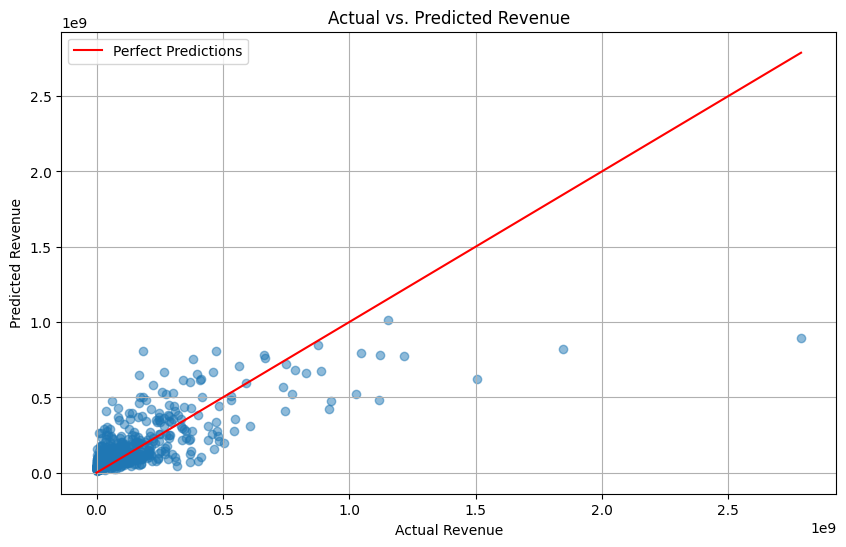

In [120]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, test_predictions, alpha=0.5)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs. Predicted Revenue')
plt.grid(True)

# Plot the identity line (y=x) to visualize accuracy
diagonal = np.linspace(start=min(Y_test), stop=max(Y_test), num=1000)
plt.plot(diagonal, diagonal, '-r', label='Perfect Predictions')
plt.legend()

plt.show()